In [25]:
from chaininglib.ui.search import create_corpus_ui
from chaininglib.ui.dfui import display_df
from chaininglib.search.CorpusQuery import *
import chaininglib.constants as constants
import re
import random

def add_corpus(name, config):
  constants.AVAILABLE_CORPORA[name] = config

add_corpus('ja_nl', {'blacklab_url':'http://corpora.ato.ivdnt.org/blacklab-server//JapansNederlands',
                     'default_method':'blacklab'})
add_corpus('chn_i', {'blacklab_url':'http://svotmc10.ivdnt.loc/blacklab-server/chn',
                     'default_method':'blacklab'})

corpus_name='zeebrieven'

def test_zeebrieven():
  corpus_name='zeebrieven'
  df_corpus = create_corpus(corpus_name).pattern("[lemma='kapitein']").group_by(["hit:word:i"]).max_results(1000).search().kwic()
  display_df(df_corpus)

def test_ja_nl():
  corpus_name='ja_nl'
  query='([pos="Verb.*" & lemma != "する"]|[pos="Noun.*"][lemma="する"]) within (<sentence/> (<s/> containing [lemma="vernietigen"]))'
  df = create_corpus(corpus_name).pattern(query).group_by(["hit:lemma:i"]).max_results(1000).search().kwic()
  display_df(df)
  plot_df(df,'identityDisplay', ['hits_per_million'])

def test_openchn(query):
  corpus = create_corpus('openchn')
  #query = "[lemma='de']"
  grouping = ['field:witnessYear_from:i']
  df = corpus.pattern(query).group_by(grouping).max_results(1000000000).search().kwic()
  display_df(df)
  plot_df(df,'identityDisplay', ['hits_per_million'])
  return df

def search_and_group(corpus_name,query, field, filter=None, validity_filter="^[0-9]{4}$"):
  corpus = create_corpus(corpus_name)
  if not filter == None:
    corpus=corpus.metadata_filter(filter)
  
  grouping = ['field:' + field + ':i']
  df = corpus.pattern(query).group_by(grouping).max_results(1000000000).search().kwic()
  
  if not validity_filter == None: # remove some data noise (non-wellformed dates etc)
     df = df[df.apply(lambda x:  re.match(validity_filter, x['identityDisplay']) != None, axis=1)]
  return df

# disable caching for query by adding a random clause 
def obfuscate(query):
  return query.replace("]", " | lemma='gna_gna_" + str(random.randint(0,1000000)) +  "']")

# simulate grouping by separate querying for each value
def silly_grouping(corpus_name, query, field, values):
    result_frames = list(map(lambda value: search_and_group(corpus_name, obfuscate(query), field, filter={field: value}, validity_filter="^[0-9]{4}$"), values))
    concatenation =  pd.concat(result_frames)
    display_df(concatenation)
    plot_df(concatenation, 'identityDisplay', 'hits_per_million')

def flatten(l):
    return [item for sublist in l for item in sublist]

def merge_frames(frames, key_field, display_field):
    merged_frame = frames[0].rename(columns={display_field: display_field + '_0'})
    for i in range(1,len(frames)):
        #print('merging:' + str(i))
        renamed_frame=frames[i].rename(columns={display_field: display_field + '_' + str(i)})
        merged_frame = pd.merge(merged_frame,renamed_frame,on=key_field,how='outer')
    return merged_frame

def search_and_group_multiple(corpus_name, queries, grouping_field, filter=None, validity_filter="^[0-9]{4}$"):
  dataframes = list(map(lambda x: search_and_group(corpus_name, x, grouping_field, filter, validity_filter), queries))

  #join the frames
  field_to_show = 'hits_per_million'
  merged = merge_frames(dataframes,'identityDisplay', field_to_show)
  
  rename_columns = {}
  for i in range(0,len(queries)):
    rename_columns[field_to_show + '_' + str(i)] = queries[i]
  renamed_frame = merged.rename(columns=rename_columns)
  
  #display_df(renamed_frame)
  plot_df(renamed_frame, 'identityDisplay', y_columns=queries  )
  return zip(queries,dataframes)
    

def plot_df(df,x_column, y_columns):
    #df_values = df[y_column].apply(lambda x: int(x))
    dfsorted = df.sort_values(by=[x_column])
    dfsorted.plot.line(x_column, y_columns, figsize=[30,15])
  

...Searching chn_i at result 0...                                                                                                       

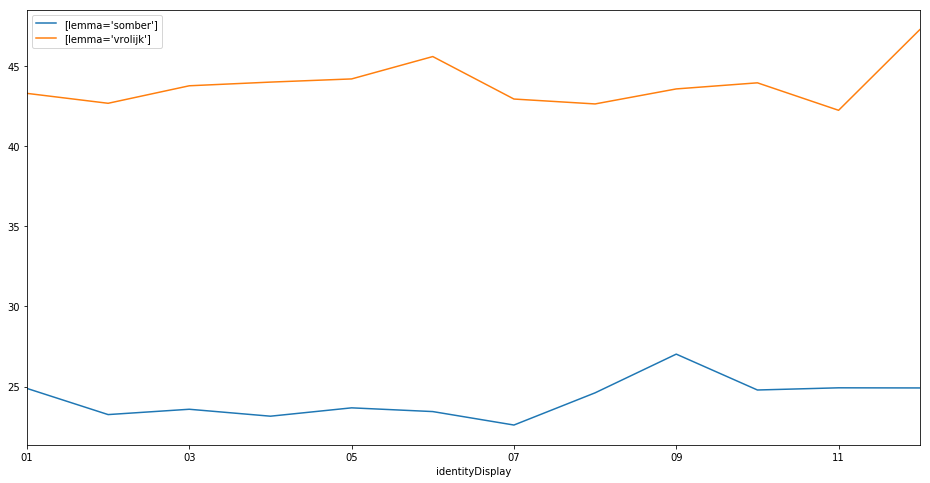

In [2]:
df = search_and_group_multiple('chn_i', ["[lemma='somber']", "[lemma='vrolijk']"], 'pubMonth_from', {'witnessYear_from': [2000,2020]}, 
                      validity_filter="^[0-9]{2}$")



...Searching chn_i at result 0...                                                                                                                                                                                                                                               

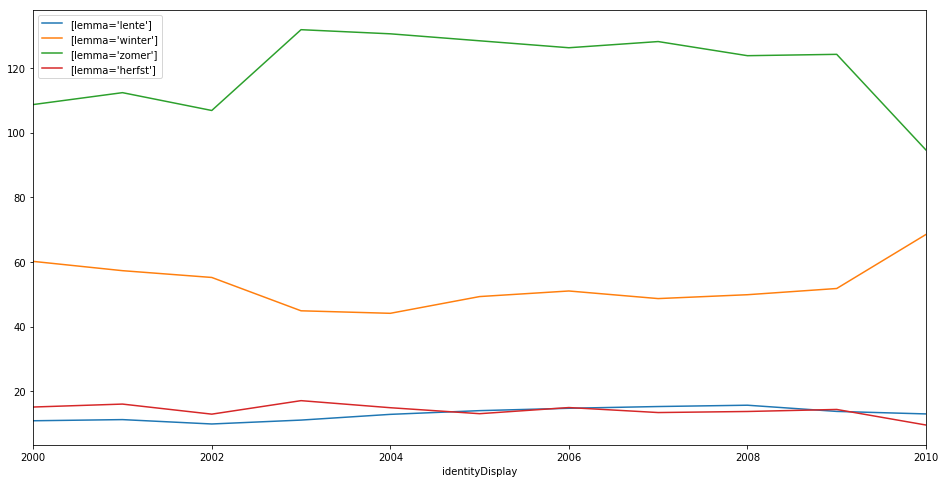

In [3]:
search_and_group_multiple('chn_i', ["[lemma='lente']", "[lemma='winter']","[lemma='zomer']", "[lemma='herfst']"], 
                          'pubYear_from',
                          {'pubYear_from': [2000,2010]})

grouping criteria:['field:witnessYear_from:i']
grouping? Truehn_i at result 0...                                
grouping criteria:['field:witnessYear_from:i']                   
...Searching chn_i at result 0...                                grouping? True
merging:1                                                        


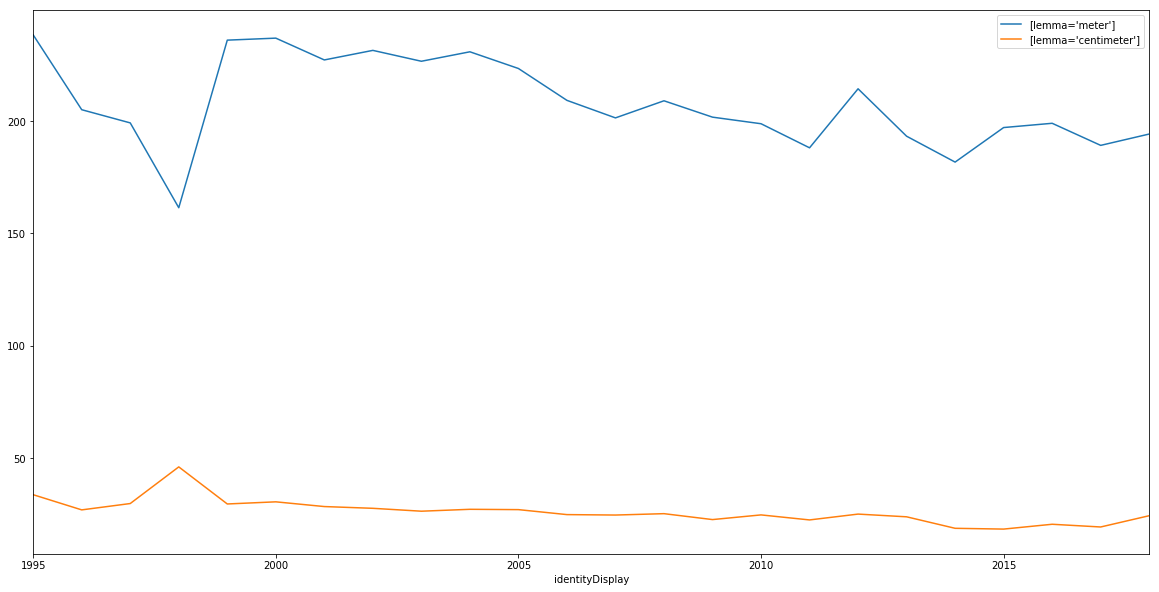

In [68]:
search_and_group_multiple('chn_i', ["[lemma='meter']", "[lemma='centimeter']"], 
                          'witnessYear_from',
                          {'witnessYear_from': [1995,2020]})

...Searching chn_i at result 0...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1995,1995,4684410,127390,129700,69682168,67225.376799
0,str:1996,1996,1184259,5911,5926,17130999,69129.593668
0,str:1997,1997,616104,11324,11474,9214430,66862.952999
0,str:1998,1998,212346,2598,2622,3517541,60367.739850
0,str:1999,1999,4599810,174971,176376,72271680,63646.092079
0,str:2000,2000,6324940,232759,234508,100345157,63031.841188
0,str:2001,2001,5731073,202570,203940,92110667,62219.427854
0,str:2002,2002,5006300,185406,186899,80263756,62373.108978
0,str:2003,2003,7391116,193432,197295,115188588,64165.349435
0,str:2004,2004,7605115,204014,209506,120774714,62969.430836


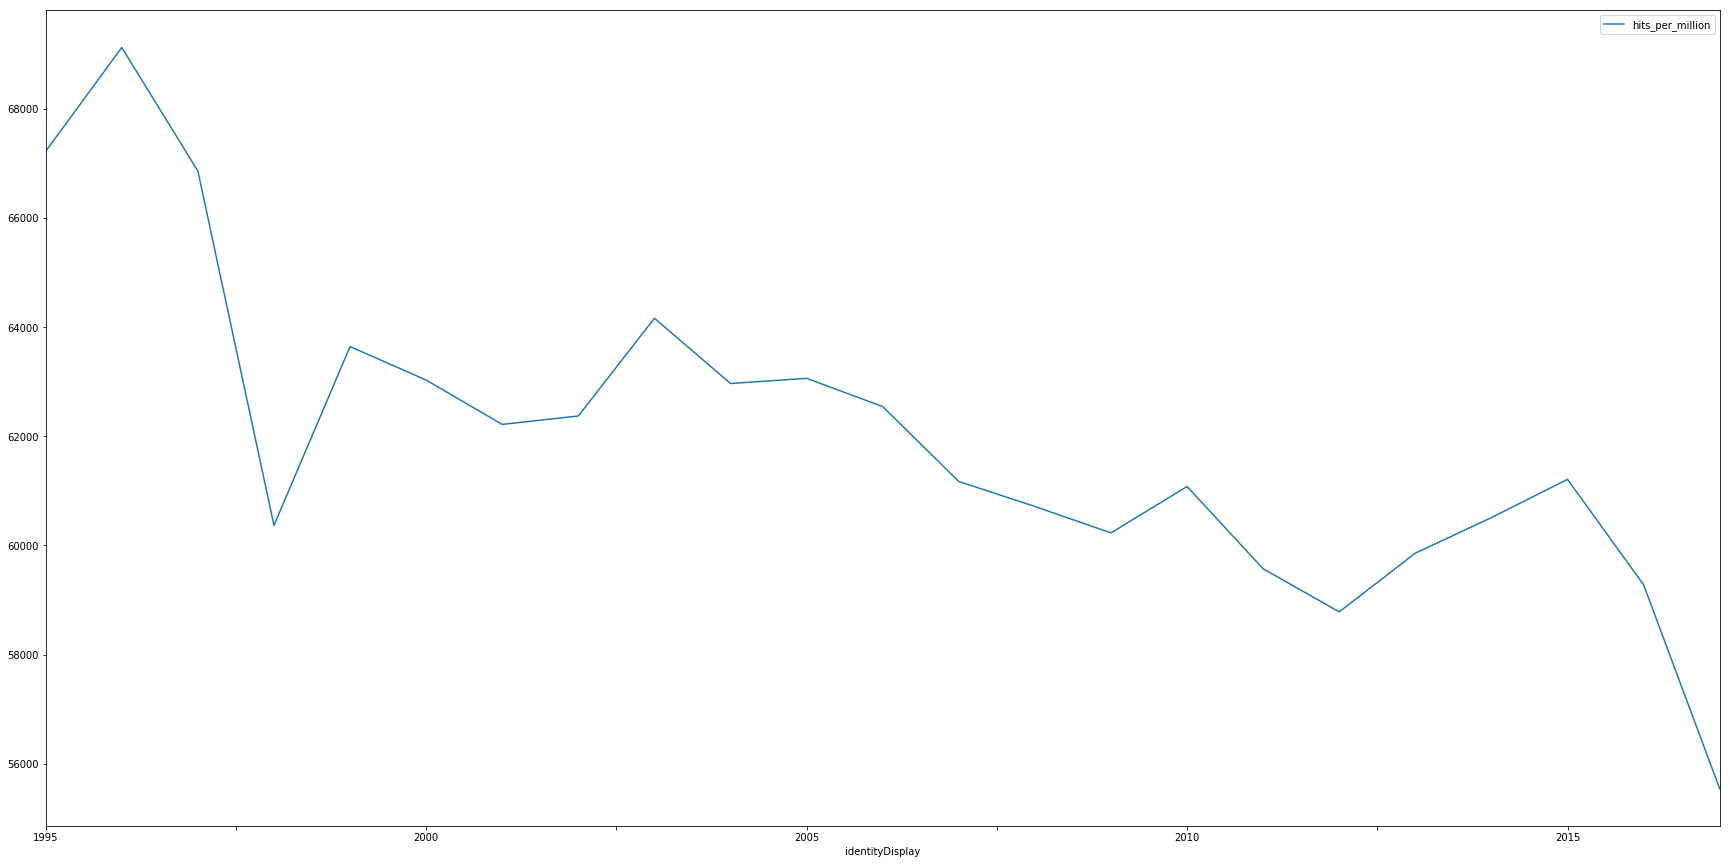

mijn_resultaten.csv saved


In [27]:
values = [str(j) for j in range(1995,2018)]
silly_grouping('chn_i', "[lemma='de']",'pubYear_from', values)

...Searching chn_i at result 0...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

,identity,identityDisplay,size,docs,subcorpus_docs,subcorpus_tokens,hits_per_million
0,str:1995,1995,1410,738,129700,69682168,20.234732
0,str:1996,1996,508,220,5926,17130999,29.653846
0,str:1997,1997,153,87,11474,9214430,16.604391
0,str:1998,1998,56,35,2622,3517541,15.920212
0,str:1999,1999,1717,1132,176376,72271680,23.757577
0,str:2000,2000,2339,1413,234508,100345157,23.309545
0,str:2001,2001,3243,1745,203940,92110667,35.207649
0,str:2002,2002,2033,1290,186899,80263756,25.328992
0,str:2003,2003,3630,1658,197295,115188588,31.513538
0,str:2004,2004,3350,1471,209506,120774714,27.737594


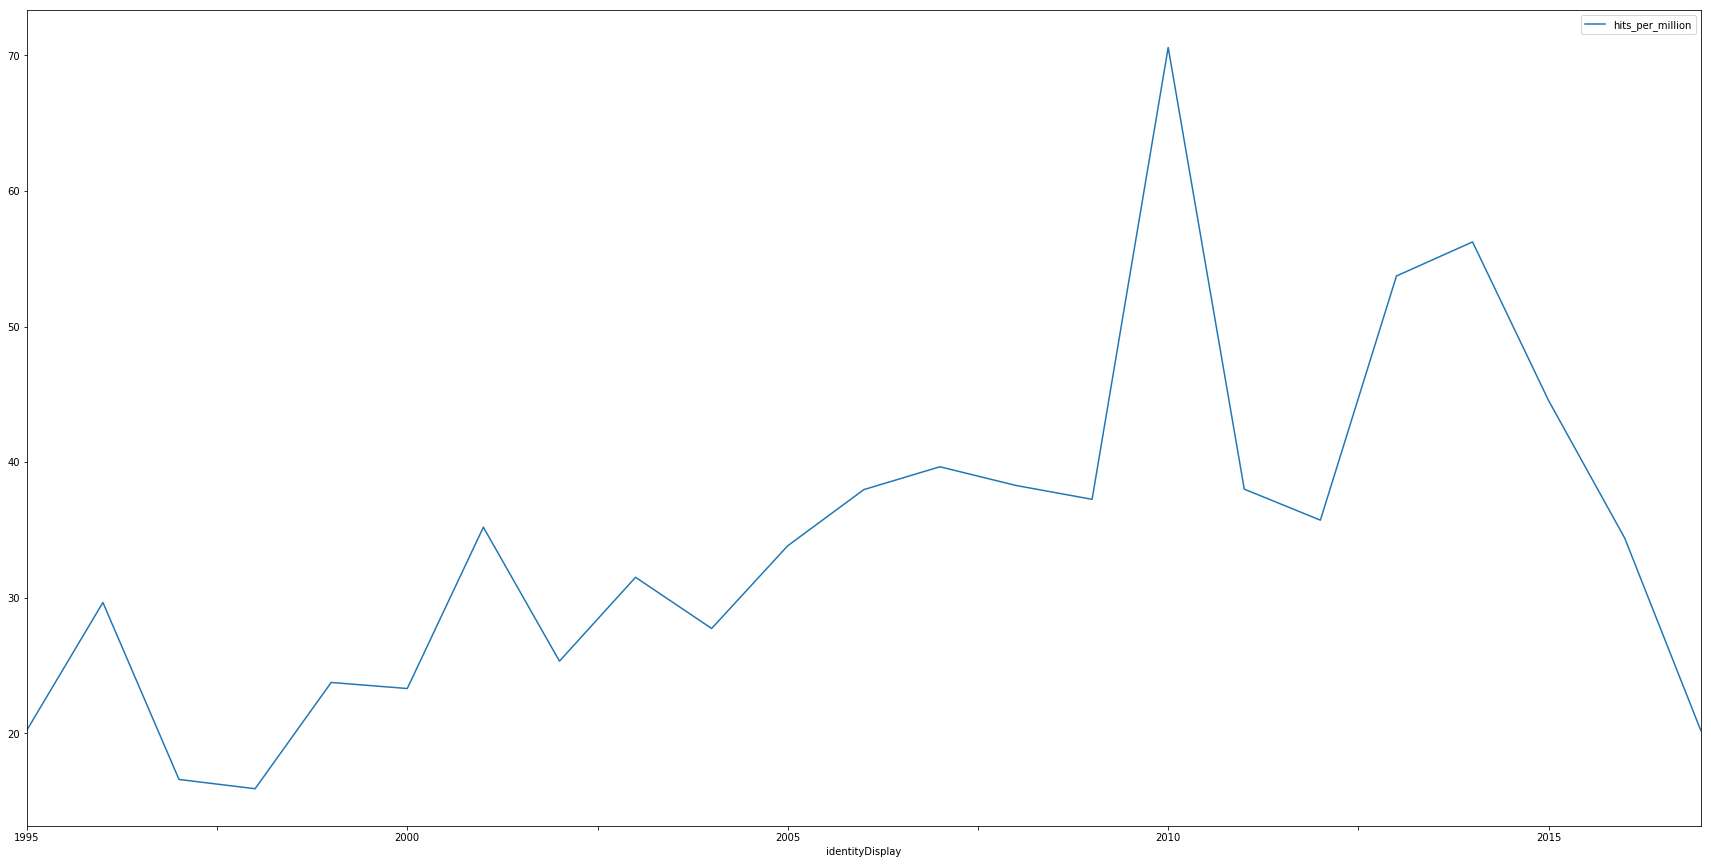

rcsv saved


In [26]:
silly_grouping('chn_i', "[lemma='brandweer']",'pubYear_from', values)